In [ ]:
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import kagglehub

In [ ]:

# Download latest version of the dataset
path = kagglehub.dataset_download("anshulm257/rice-disease-dataset")
print("Dataset is here:", path)
print(os.listdir(path))   # list folders/files inside dataset

100%|██████████| 0.99G/0.99G [00:09<00:00, 118MB/s]

Extracting files...


Dataset is here: /root/.cache/kagglehub/datasets/anshulm257/rice-disease-dataset/versions/1
['Rice_Leaf_AUG']


In [ ]:
# Path to dataset
DATASET_DIR = os.path.join(path, "Rice_Leaf_AUG")
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

In [ ]:
# Data generator
datagen = ImageDataGenerator(rescale=1./255)
all_data_gen = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

filenames = all_data_gen.filepaths
classes = all_data_gen.classes
class_labels = list(all_data_gen.class_indices.keys())

data = pd.DataFrame({
    'filename': filenames,
    'class': [class_labels[k] for k in classes]
})

Found 3829 images belonging to 6 classes.


In [ ]:
# Train/val/test split
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['class'], random_state=SEED)
val_data, test_data = train_test_split(test_data, test_size=0.5, stratify=test_data['class'], random_state=SEED)

In [ ]:
train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED
)

Found 3063 validated image filenames belonging to 6 classes.


In [ ]:
val_generator = datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED
)

Found 383 validated image filenames belonging to 6 classes.


In [ ]:
test_generator = datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 383 validated image filenames belonging to 6 classes.


In [ ]:
# Model building with EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Test evaluation
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.2f}")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


383/383 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.1675 - loss: 1.8078
Test accuracy: 0.16


In [ ]:
# Fine-tune model
model.trainable = True
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 166s 907ms/step - accuracy: 0.2258 - loss: 1.7745 - val_accuracy: 0.1723 - val_loss: 1.7931
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 25s 260ms/step - accuracy: 0.4953 - loss: 1.5889 - val_accuracy: 0.1671 - val_loss: 1.7909
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 25s 261ms/step - accuracy: 0.6078 - loss: 1.3680 - val_accuracy: 0.1958 - val_loss: 1.7904
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 25s 255ms/step - accuracy: 0.6440 - loss: 1.1581 - val_accuracy: 0.1645 - val_loss: 1.8395
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 25s 264ms/step - accuracy: 0.7079 - loss: 0.9537 - val_accuracy: 0.1775 - val_loss: 2.0314
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 25s 260ms/step - accuracy: 0.7570 - loss: 0.8036 - val_accuracy: 0.1906 - val_loss: 2.2213
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 25s 259ms/step - accuracy: 0.7816 - loss: 0.6932 - val_accuracy: 0.3368 - val_loss: 1.7404
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 256ms/step - accuracy: 0.8155 - loss: 0.5946 - val_acc

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.2f}")

383/383 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.4470 - loss: 1.5301
Test accuracy: 0.45


In [ ]:
# Load 95% accuracy model
model.save("/content/rice_disease_model_1.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


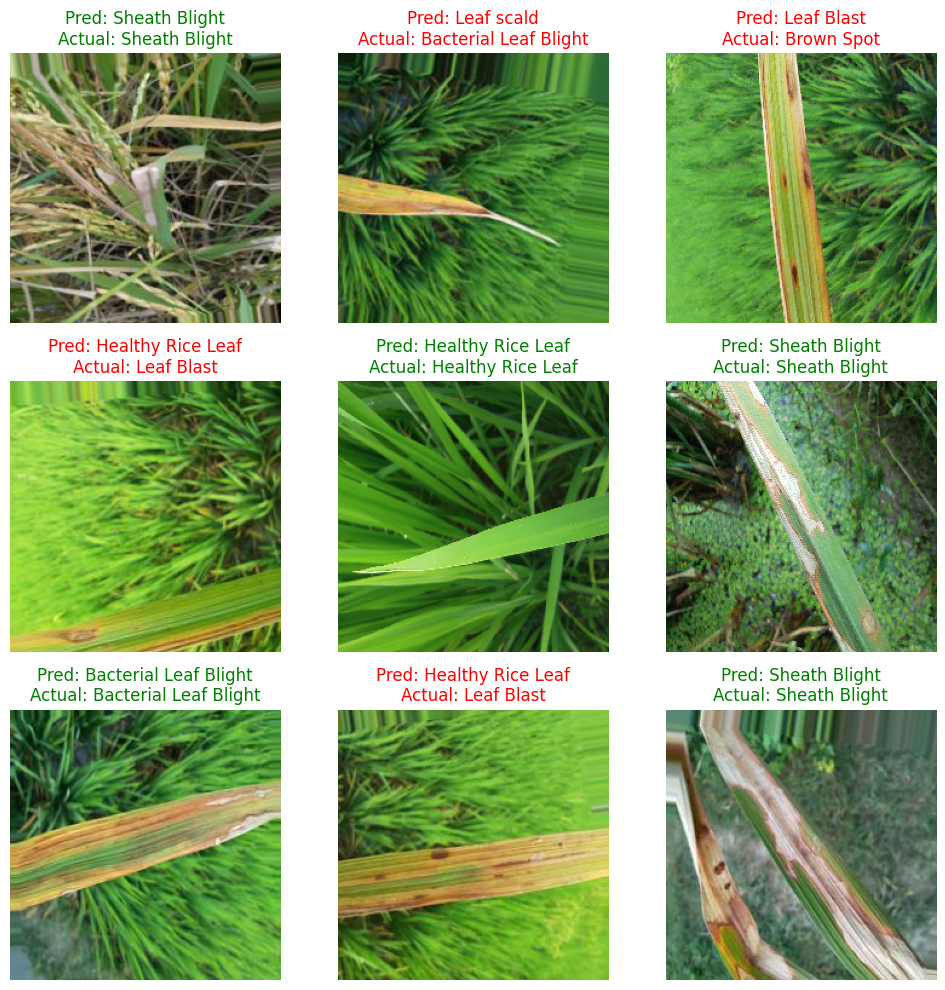

In [ ]:
# Predictions visualization
filenames = test_generator.filenames
classes = test_generator.classes
labels = list(test_generator.class_indices.keys())

random_indices = random.sample(range(len(filenames)), 9)
images = []
actual_labels = []
predicted_labels = []

for idx in random_indices:
    img, label = test_generator[idx]
    images.append(img[0])
    actual_labels.append(classes[idx])
    pred = model.predict(img)
    predicted_labels.append(np.argmax(pred))

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    actual_class = labels[actual_labels[i]]
    predicted_class = labels[predicted_labels[i]]
    color = 'green' if actual_class == predicted_class else 'red'
    plt.title(f"Pred: {predicted_class}\nActual: {actual_class}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Learning rate scheduler
lr_schedule = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7
)

In [17]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop, lr_schedule]
)

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 28s 284ms/step - accuracy: 0.8858 - loss: 0.3654 - val_accuracy: 0.6110 - val_loss: 1.0249 - learning_rate: 1.0000e-05
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 25s 260ms/step - accuracy: 0.9040 - loss: 0.3326 - val_accuracy: 0.6710 - val_loss: 0.8953 - learning_rate: 1.0000e-05
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 25s 259ms/step - accuracy: 0.9134 - loss: 0.2788 - val_accuracy: 0.7232 - val_loss: 0.7637 - learning_rate: 1.0000e-05
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 25s 261ms/step - accuracy: 0.9258 - loss: 0.2595 - val_accuracy: 0.7493 - val_loss: 0.7359 - learning_rate: 1.0000e-05
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 25s 263ms/step - accuracy: 0.9368 - loss: 0.2187 - val_accuracy: 0.5979 - val_loss: 1.0530 - learning_rate: 1.0000e-05
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 25s 264ms/step - accuracy: 0.9406 - loss: 0.1996 - val_accuracy: 0.7833 - val_loss: 0.6403 - learning_rate: 1.0000e-05
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 25s 261ms/step - acc

In [18]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.2f}")

383/383 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9662 - loss: 0.1511
Test accuracy: 0.95


In [19]:
model.save("/content/rice_disease_model_2.h5")

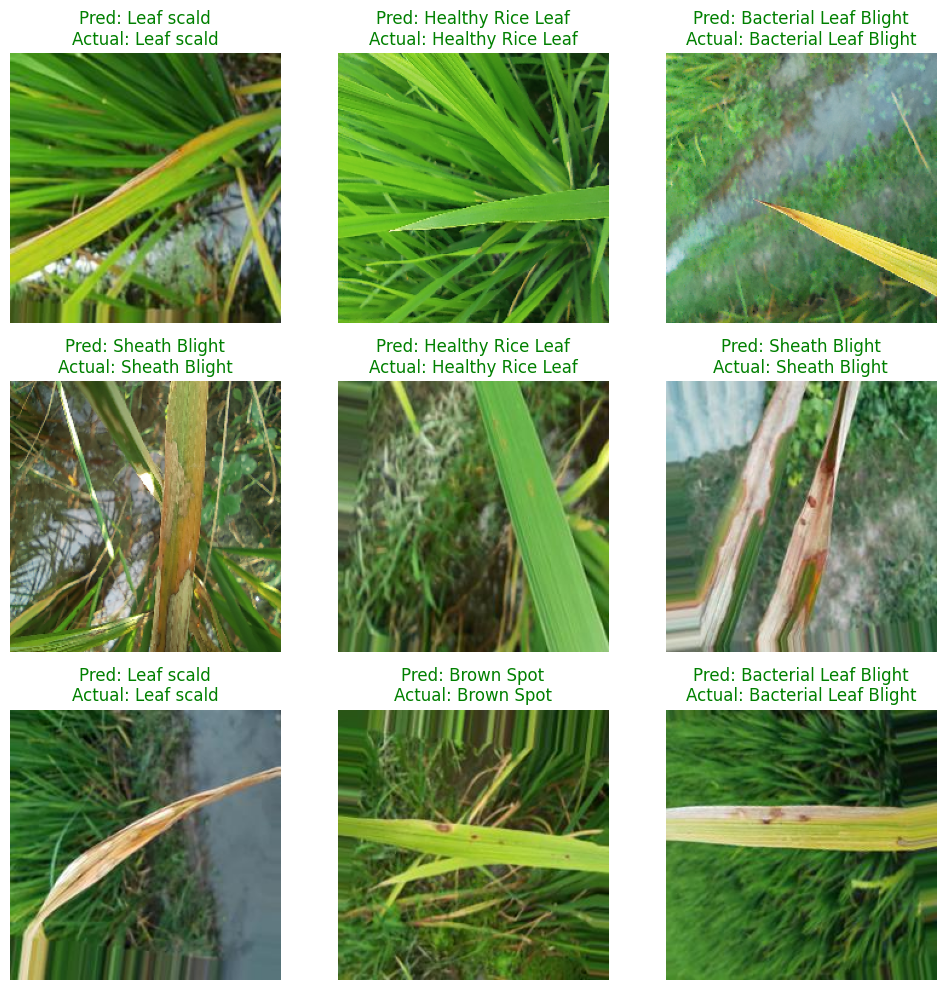

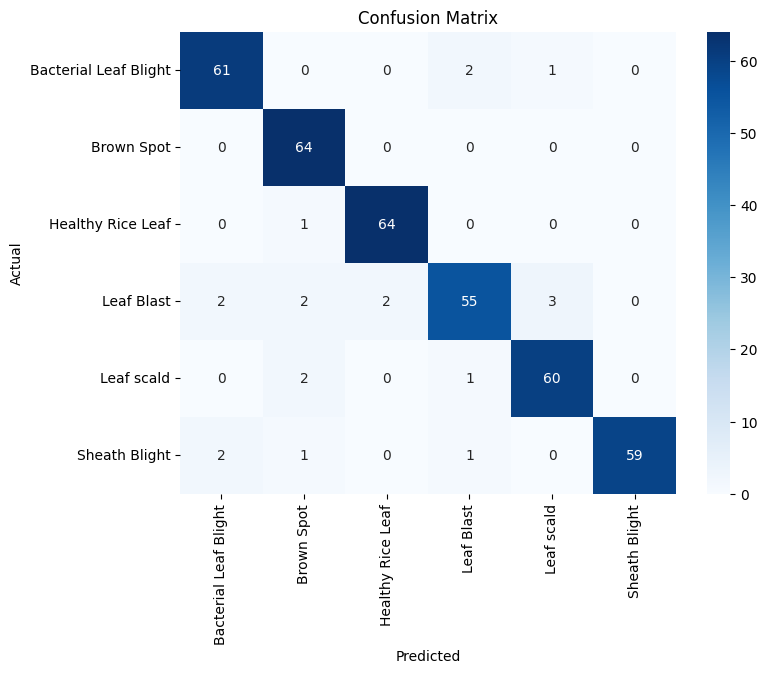

                       precision    recall  f1-score   support

Bacterial Leaf Blight       0.94      0.95      0.95        64
           Brown Spot       0.91      1.00      0.96        64
    Healthy Rice Leaf       0.97      0.98      0.98        65
           Leaf Blast       0.93      0.86      0.89        64
           Leaf scald       0.94      0.95      0.94        63
        Sheath Blight       1.00      0.94      0.97        63

             accuracy                           0.95       383
            macro avg       0.95      0.95      0.95       383
         weighted avg       0.95      0.95      0.95       383



In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# --- Random 9 predictions visualization ---
filenames = test_generator.filenames
classes = test_generator.classes
labels = list(test_generator.class_indices.keys())

random_indices = random.sample(range(len(filenames)), 9)
images = []
actual_labels = []
predicted_labels = []

for idx in random_indices:
    img, label = test_generator[idx]   # batch with 1 image
    images.append(img[0])
    actual_labels.append(classes[idx])
    pred = model.predict(img, verbose=0)
    predicted_labels.append(np.argmax(pred))

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    actual_class = labels[actual_labels[i]]
    predicted_class = labels[predicted_labels[i]]
    color = 'green' if actual_class == predicted_class else 'red'
    plt.title(f"Pred: {predicted_class}\nActual: {actual_class}", color=color)
    plt.axis('off')
plt.tight_layout()
plt.show()

# --- Confusion Matrix for entire test set ---
y_true = test_generator.classes
y_pred = model.predict(test_generator, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# --- Classification Report ---
print(classification_report(y_true, y_pred_classes, target_names=labels))